---
title: "Testing known repeaters with limited samples"
date: "2023-08-09"

---

# FRB20180916B

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

from astropy.timeseries import LombScargle
from astropy.time import Time

DATAPATH = os.getenv('DATAPATH')
CATALOG_PATH = Path(DATAPATH, 'raw', 'catalog2023', 'catalog2023_profile.parquet')
CATALOG_PATH_CSV = Path(DATAPATH, 'raw', 'catalog2023', 'chimefrb2023repeaters.csv')
CATALOG1_PATH_PARQUET = Path(DATAPATH, 'catalog_1.parquet')

cat1 = pd.read_parquet(CATALOG1_PATH_PARQUET)[["eventname","repeater_name", "mjd_400"]]
cat1['catalog'] = 'Catalog 1'
cat2023 = pd.read_csv(CATALOG_PATH_CSV)[["tns_name","repeater_name","mjd_400"]].rename(columns={'tns_name':'eventname'})
cat2023['catalog'] = 'Catalog 2023'
data = pd.concat([cat1, cat2023])
data['mjd'] = data['mjd_400']
data

,eventname,repeater_name,mjd_400,catalog,mjd
0,FRB20180725A,-9999,58324.749803,Catalog 1,58324.749803
1,FRB20180727A,-9999,58326.036262,Catalog 1,58326.036262
2,FRB20180729A,-9999,58328.033565,Catalog 1,58328.033565
3,FRB20180729B,-9999,58328.728032,Catalog 1,58328.728032
4,FRB20180730A,-9999,58329.151134,Catalog 1,58329.151134
...,...,...,...,...,...
146,FRB20210313E,FRB20201221B,59286.202113,Catalog 2023,59286.202113
147,FRB20210331F,FRB20210323C,59304.147737,Catalog 2023,59304.147737
148,FRB20210331F,FRB20210323C,59304.147737,Catalog 2023,59304.147737
149,FRB20210426B,FRB20210323C,59330.091835,Catalog 2023,59330.091835


In [2]:
import seaborn as sns

chosen_name = 'FRB20180916B' # (77)
# chosen_name = 'FRB20190915D' # 👍 (10)

selected = data[['repeater_name', 'mjd', 'catalog']].sort_values(by='mjd')
selected[chosen_name] = (selected['repeater_name'] == chosen_name).astype(int)
# detections = selected[chosen_name].sum()
selected['datetime'] = Time(selected['mjd'], format='mjd').to_datetime()
to_plot=selected.set_index('datetime').resample('d').sum()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14700\2761106111.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  to_plot=selected.set_index('datetime').resample('d').sum()


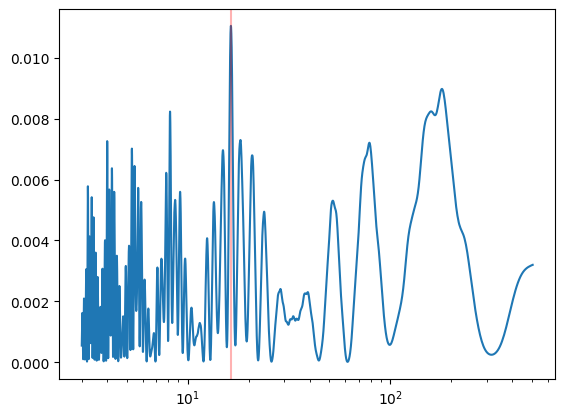

In [3]:
import astropy.units as u

time = Time(to_plot.index.to_numpy())
obs = to_plot[chosen_name].to_numpy()

freq_min = 1 / (3 * u.day)
freq_max = 1/(len(to_plot) *.5 * u.day)

freq_grid = np.linspace(freq_max,freq_min, 10_000)

LS = LombScargle(time, obs)
power = LS.power(freq_grid)

period = 1/freq_grid[np.nanargmax(power)]

g = sns.lineplot(x=1/freq_grid, y=power)
g.axvline(period.value, color='red', alpha=0.3)
# g.axvline(2*period.value, color='red', alpha=0.3)
# g.axvline(3*period.value, color='red', alpha=0.3)
# g.axvline(0.5*period.value, color='red', alpha=0.3)
# g.axvline(0.25*period.value, color='red', alpha=0.3)
# g.set_ylim(0,0.003)
g.set_xscale('log')

In [4]:
1/freq_grid[np.nanargmax(power)]

<Quantity 16.33002105 d>

## Limited Window

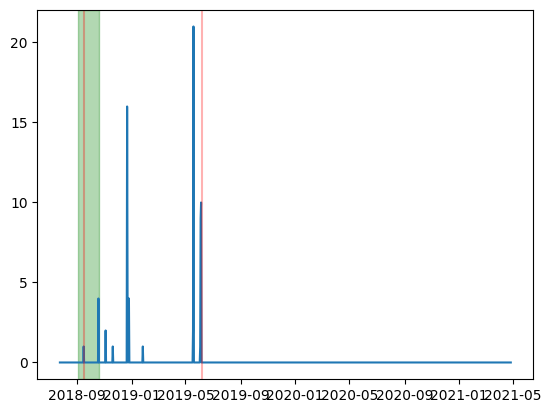

In [6]:
expected = 16
observation = 3*expected
offset = 40

page = 0
window = offset+page*observation
limited = to_plot[window:window+observation]

g = sns.lineplot(x=to_plot.index.to_numpy(), y=to_plot[chosen_name].to_numpy())
g.axvspan(to_plot.index[window], to_plot.index[window+observation], color='green', alpha=0.3)
g.axvline(to_plot.index[-691], color='red', alpha=0.3)
g.axvline(to_plot.index[53], color='red', alpha=0.3)

In [8]:
from copy import deepcopy


def get_first_and_last_index(items: list) -> (int, int):
    first = 0
    last = 0
    for item in deepcopy(items):
        if item == 0:
            first += 1
        elif item > 0:
            break
    for item in deepcopy(items)[::-1]:
        if item == 0:
            last -= 1
        elif item > 0:
            break
    return first, last

get_first_and_last_index(to_plot[chosen_name].to_numpy())

(53, -691)

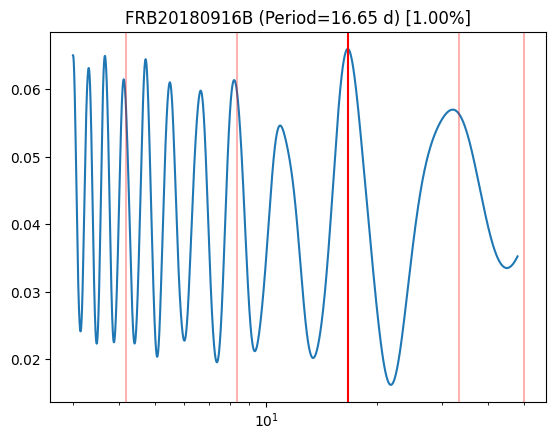

In [8]:
limited_time = Time(limited.index.to_numpy())
limited_obs = limited[chosen_name].to_numpy()

assert np.sum(limited_obs) > 0, "No Observation found"

freq_min = 1 / (3 * u.day)
freq_max = 1/(len(limited) * u.day)

freq_grid = np.linspace(freq_max,freq_min, 10_000)

LS = LombScargle(limited_time, limited_obs)
power = LS.power(freq_grid)

period = 1/freq_grid[np.nanargmax(power)]

false_alarm_prob = LS.false_alarm_probability(1/period)

g = sns.lineplot(x=1/freq_grid, y=power)
g.axvline(period.value, color='red', alpha=1)
g.axvline(2*period.value, color='red', alpha=0.3)
g.axvline(3*period.value, color='red', alpha=0.3)
g.axvline(0.5*period.value, color='red', alpha=0.3)
g.axvline(0.25*period.value, color='red', alpha=0.3)
# g.set_ylim(0,0.003)
g.set_title(f"{chosen_name} (Period={period.value:.2f} d) [{false_alarm_prob:.2f}%]")
g.set_xscale('log')

In [6]:
def get_first_and_last_index(items: list) -> (int, int):
    first = 0
    last = 0
    for item in deepcopy(items):
        if item == 0:
            first += 1
        elif item > 0:
            break
    for item in deepcopy(items)[::-1]:
        if item == 0:
            last -= 1
        elif item > 0:
            break
    return first, last
    
def periodicity_within_window(t: np.array, y: np.array, expected_period: float, multiplier: int, offset: int) -> (float, float):
    window = int(np.ceil(multiplier*expected_period))
    limited_t = Time(t[offset+window:offset+(2*window)])
    limited_y = y[offset+window:offset+(2*window)]

    if np.sum(limited_y) == 0:
        raise ValueError("No Observation found.")

    freq_min = 1 / (3 * u.day)
    freq_max = 1/(len(limited_t) * u.day)

    freq_grid = np.linspace(freq_max,freq_min, 10_000)

    LS = LombScargle(limited_t, limited_y)
    power = LS.power(freq_grid)

    period = 1/freq_grid[np.nanargmax(power)]
    false_alarm_prob = LS.false_alarm_probability(1/period)
    return period, false_alarm_prob

In [9]:
from collections import defaultdict


first, last = get_first_and_last_index(to_plot[chosen_name].to_numpy())
biggest_window = len(to_plot[first:last])
# if window > biggest_window:
#     ...

results = defaultdict()
for multiplier in range(2,30):
    periods = []
    fa_probs = []
    for offset in (offsets:=range(45, biggest_window + first)):
        try:
            period, fa_prob = periodicity_within_window(to_plot.index.to_numpy(), to_plot[chosen_name].to_numpy(), 16, multiplier, offset)
            periods.append(period.value)
            fa_probs.append(fa_prob.value)
        except ValueError:
            pass
            # periods.append(None)
            # fa_probs.append(None)
    try:
        results[multiplier] = np.median(periods), np.std(periods), np.mean(periods), np.min(periods), np.max(periods)
    except ValueError:
        pass


d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\home\kerja\sarjana\.venv\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


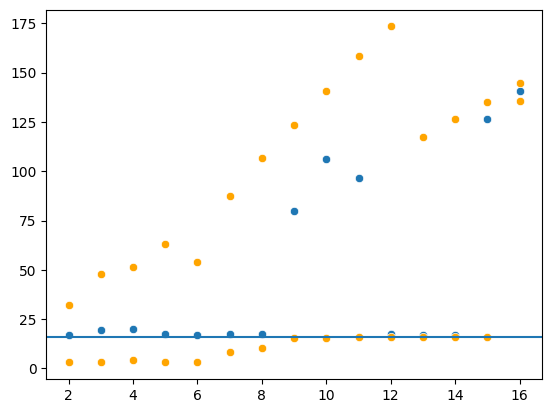

In [10]:
medians = [v[0] for k, v in results.items()]
maxi = [v[-1] for k, v in results.items()]
mini = [v[-2] for k, v in results.items()]

g=sns.scatterplot(x=results.keys(), y=medians)
sns.scatterplot(x=results.keys(), y=maxi, color='orange', ax=g)
sns.scatterplot(x=results.keys(), y=mini, color='orange', ax=g)
g.axhline(16)

# Phase Dispersion Minimization

23.558435207823923

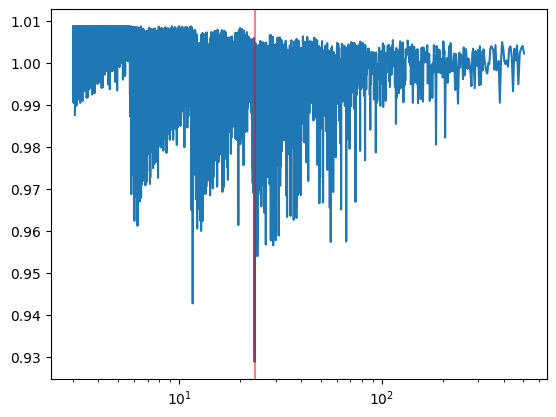

In [50]:
from pdmpy import pdm
import matplotlib.pyplot as plt

time = to_plot.index.to_numpy()
obs = to_plot[chosen_name].to_numpy()

freq_min = 1 / (3 * u.day)
freq_max = 1/(len(to_plot) *.5 * u.day)

f, theta = pdm(time, obs, f_min=freq_max.value, f_max=freq_min.value, delf=freq_grid.diff()[0].value)

plt.plot(1/f, theta)
plt.semilogx()
plt.axvline(period_pdm:=1/f[np.nanargmin(theta)], color='red', alpha=0.5)
period_pdm

In [ ]:
detections = selected.loc[selected[chosen_name] == 1].index

best_periods = []
for idx in detections:
    folded = selected.loc[selected.index != idx, ['mjd', chosen_name]]
    folded['datetime'] = Time(folded['mjd'], format='mjd').to_datetime()
    reduced = folded.set_index('datetime').resample('d').sum()
    t = reduced.index
    obs = reduced['obs']
    freq, theta = pdm(t, obs, f_min=freq_max.value, f_max=freq_min.value, delf=freq_grid.diff()[0])
    best_periods.append(1/freq[np.nanargmax(theta)].value)